# Seal Detection Pipeline
---

This jupyter notebook will go through assembling the main components of a complete pipeline for counting seals in high-resolution satellite imagery (figure 1, steps 3 and 4) and show some experimental results with different pipeline designs. The ultimate goal of this pipeline is to perform a pan-Antarctic pack-ice seal census. ** Running this code will require input satellite imagery and at least one GPU with >8GB of memory **

<br>

<img src="jupyter_notebook_images/Base Pipeline.png">

<br>







## Table of contents
---
* [Getting started](#intro)
    * [Setup](#setup)
    * [Visualize training set](#vis_imgs)
* [Pipeline 1 - Seal haulout detector](#1)
    * [Training](#1T)
    * [Validation](#1V)
* [Pipeline 1.1 - Seal haulout detector + count](#1.1)
    * [Training](#1.1T)
    * [Validation](#1.1V)
    * [Testing](#1.1T)
* [Pipeline 1.2 - Seal haulout detector + single seal detector](#1.2)
    * [Training](#1.2T)
    * [Validation](#1.2V)
    * [Testing](#1.2T)

## Getting started<a name="intro"></a>
---

If you followed the *training_set_generation* jupyter notebook (also present in this repo), you should have training sets generated and hyperparameter sets to try out, and be ready to search for a best performing seal detection pipeline.  Output files in this repository are organized as follows: *'./saved_models_stable/{pipeline}/{model_settings}/{model_settings}_{file}'*

### Setup environment<a name="setup"></a>

Before training and validating model/hyperparameter combinations inside the pipelines, we need to load the required python modules and a few global variables. Running this script will also display a list of training classes.

In [1]:
# import required packages
import os
import rasterio
import pandas as pd
import numpy as np
import operator
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import reduce
from utils.model_library import * 

%matplotlib inline
mpl.rcParams['figure.dpi']= 400

# display class names
class_names = sorted([subdir for subdir in os.listdir('./training_sets/training_set_vanilla/training')])
print(class_names)

# destination folder for saved models and model stats
dest_folder = 'saved_models_stable'

['crabeater', 'crack', 'emperor', 'glacier', 'ice-sheet', 'marching-emperor', 'open-water', 'other', 'pack-ice', 'rock', 'weddell']


### Visualizing training images (Optional)<a name="vis_imgs"></a>

To get a better sense for what the training set is like, the next cell will display a few random images from the training classes. Displayed images are extracted from a pool of ~70000 training images. 

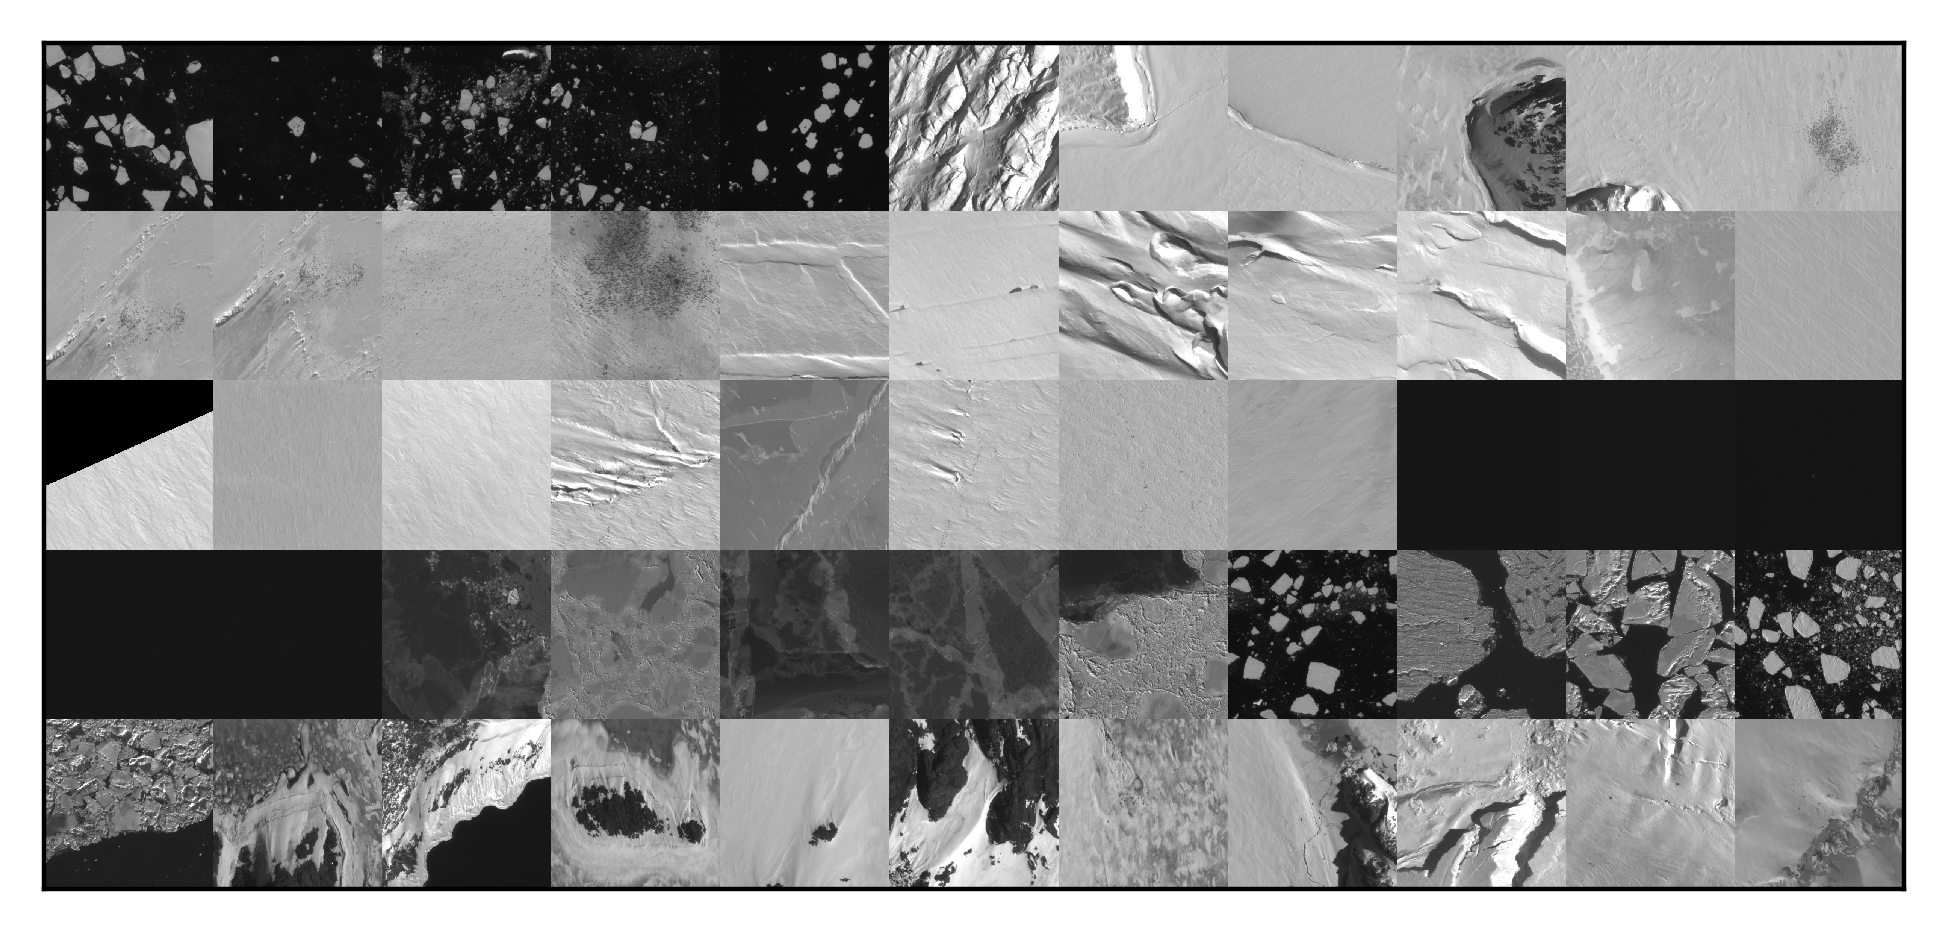

In [2]:
# store images
images = []

# loop over labels
for label in class_names:
    for path, _, files in os.walk('./training_sets/training_set_vanilla/training/{}'.format(label)):
        files = np.random.choice(files, 5)
        for filename in files:
            images.append(np.asarray(Image.open(os.path.join(path, filename))))

images = np.array(images)

# display images 
ncols=len(class_names)
nindex, height, width, intensity = images.shape
nrows = nindex//ncols
assert nindex == nrows*ncols
result = (images.reshape(nrows, ncols, height, width, intensity)
          .swapaxes(1,2)
          .reshape(height*nrows, width*ncols, intensity))

plt.imshow(result)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()
    


## Pipeline 1 - haulout detector<a name="1"></a>
---

The simplest pipeline we can use is one that just uses an object classification step to find seal haulouts or penguins colonies. The obvious downside for this approach is that we often have more than one seal in a haulout, which is hardly usefull if we are looking for a count. However, we will use this as a 'pre-preocessing' step, where we narrow down the totality of patches to the subset where the haulout detection CNN flagged groups of seals. To validate the usefulness of this preprocessing step we can compare results obtained with the full pipeline (i.e. haul out detector + count) to one that simply tries to count on all tiles. 

### Training<a name="1T"></a>

The first step to find a best performing model is to train different model setups using our training set. To keep track of which combinations we have tried, how well they performed and the specifics of each model setup, we will store results in folders (under './saved_models') named after each specific model combination.

In [3]:
# generate model combinations
combinations_1 = {'model_architecture': ['Resnet18', 'Resnet34', 'Resnet50', 'Squeezenet11',
                                         'Alexnet', 'NasnetA', 'Densenet121','Densenet169', 
                                         'VGG16'],
                  'training_dir': ['training_set_vanilla'] * 9,
                  'hyperparameter_set': ['B'] * 9,
                  'cv_weights': ['NO'] * 9}

# read as a DataFrame
combinations_1 = pd.DataFrame(combinations_1)
                    
# create folders for resulting files
for row in combinations_1.iterrows():
    mdl = row[1]['model_architecture']                  
    if not os.path.exists("./saved_models_stable/Pipeline1/{}".format(mdl)):
        os.makedirs("./saved_models_stable/Pipeline1/{}".format(mdl)) 


We can then provide model combinations created above as arguments to the training script, *train_sealnet.py*. A list of required arguments can be displayed by running the cell below.

In [4]:
%run train_sealnet.py -h

usage: train_sealnet.py [-h] [--training_dir TRAINING_DIR]
                        [--model_architecture MODEL_ARCHITECTURE]
                        [--hyperparameter_set HYPERPARAMETER_SET]
                        [--cv_weights [CV_WEIGHTS]]
                        [--output_name OUTPUT_NAME] [--pipeline PIPELINE]
                        [--dest_folder DEST_FOLDER]

trains a CNN to find seals in satellite imagery

optional arguments:
  -h, --help            show this help message and exit
  --training_dir TRAINING_DIR
                        base directory to recursively search for images in
  --model_architecture MODEL_ARCHITECTURE
                        model architecture, must be a member of models
                        dictionary
  --hyperparameter_set HYPERPARAMETER_SET
                        combination of hyperparameters used, must be a member
                        of hyperparameters dictionary
  --cv_weights [CV_WEIGHTS]
                        weights for weighted-cross

In [5]:
# iterate over combinations
pipeline = 'Pipeline1'
for row in combinations_1.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st, cv_wgt = row[1]['training_dir'], row[1]['model_architecture'], \
                                  row[1]['hyperparameter_set'], row[1]['cv_weights']
    out = arch
    
    # check if model is already trained
    if "{}.tar".format(out) in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} was already trained'.format(out))
        continue
    
    print()
    !echo training $out
    print()
    
    # run training
    !python train_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                             --hyperparameter_set=$hyp_st --cv_weights=$cv_wgt \
                             --output_name=$out --pipeline=$pipeline \
                             --dest_folder='saved_models_stable'
      

Resnet18 was already trained
Resnet34 was already trained
Resnet50 was already trained
Squeezenet11 was already trained
Alexnet was already trained
NasnetA was already trained
Densenet121 was already trained
Densenet169 was already trained
VGG16 was already trained


### Validation<a name="1V"></a> 

We can now load the models we just trained to get measurements of precision and recall for all positive classes. For every model combination we trained, *validate_sealnet.py* will run a full validation round and write given label/correct label pairs to a .csv file. The resulting .csv file is then imported by an R script, *plot_confusion_matrix.R*, which saves a confusion matrix figure and a .csv spreadsheet with precision and recall for all classes of interest. 

In [6]:
# DataFrame to combine all metrics 
comb_prec_recall = pd.DataFrame()
pipeline = 'Pipeline1'

# iterate over trained models
for row in combinations_1.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st, cv_wgt = row[1]['training_dir'], row[1]['model_architecture'],\
                                  row[1]['hyperparameter_set'], row[1]['cv_weights']
    out = arch
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} has not been trained yet'.format(out))
        continue
        
    else:
        print()
        !echo validating $out
        print()
        
        #run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                                    --hyperparameter_set=$hyp_st --model_name=$out \
                                    --pipeline=$pipeline --dest_folder='saved_models_stable'
        
        # extract performance metrics and plot confusion matrix
        !Rscript plot_confusion_matrix.R --input_file=$out --pipeline=$pipeline \
                                         --dest_folder='saved_models_stable'
        
        # accumulate performance scores
        comb_prec_recall = comb_prec_recall.append(pd.read_csv('./saved_models_stable/{}/{}/{}_prec_recall.csv'.format(pipeline, out, out)))
    
    
# Write combined metrics to csv and plot combined metrics
pooled_data_path = './saved_models_stable/{}/pooled_prec_recall.csv'.format(pipeline)
comb_prec_recall.to_csv(pooled_data_path)
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1/comparison_plot.png' \
                           --x='recall' --y='precision' --facet='label'
    


validating Resnet18

Validation complete in 0.0h 0m 39s
Validation Acc: 0.893142

validating Resnet34

Validation complete in 0.0h 0m 58s
Validation Acc: 0.869381

validating Resnet50

Validation complete in 0.0h 1m 38s
Validation Acc: 0.887233

validating Squeezenet11

/home/bento/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/bento/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
Validation complete in 0.0h 0m 23s
Validation Acc: 0.499486

validating Alexnet

Validation complete in 0.0h 0m 18s
Validation Acc: 0.760853

validating NasnetA

Validation complete in 0.0h 4m 43s
Validation Acc: 0.930259

validating Densenet121

/home/bento/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torch

## Pipeline 1.1 - haulout detector + count<a name="1.1"></a>
---

Here we will generate seal counting CNNs, train them and validate them. Seal counting CNNs will be trained to minimize the mean squared error (MSE) between predicted counts and ground-truth counts. Though they will be trained and validated separately from the haul out detector (Pipeline 1), these approaches will be tested on top of the haul out detector and as standalones.

### Training<a name="1.1T"></a>

Similar to the previous pipeline, we will store results in folders (under './saved_models') named after each specific model combination for bookkeeping.

In [2]:
# generate model combinations
combinations_11 = {'model_architecture': ['WideResnetCount', 'Resnet34count', \
                                          'Resnet18count', 'Resnet50count', \
                                          'NasnetAcount', 'CountCeption'],
                   'training_dir': ['training_set_vanilla'] * 6,
                   'hyperparameter_set': ['D'] + ['A'] * 2 + ['B'] * 3}       

# read as a DataFrame
combinations_11 = pd.DataFrame(combinations_11)
                    

# create folders for resulting files
for row in combinations_11.iterrows():
    mdl = row[1]['model_architecture']                     
    if not os.path.exists("./saved_models_stable/Pipeline1.1/{}".format(mdl)):
        os.makedirs("./saved_models_stable/Pipeline1.1/{}".format(mdl)) 

To train a counting model, model combinations created above are used as argument to to a new training script, *train_sealnet_count.py*, which uses MSE loss. It accepts the same arguments as the previous.

In [8]:


# iterate over combinations
pipeline = 'Pipeline1.1'




for row in combinations_11.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st = row[1]['training_dir'], row[1]['model_architecture'], \
                          row[1]['hyperparameter_set']
    out = arch
    
    # check if model is already trained
    if "{}.tar".format(out) in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} was already trained'.format(out))
        continue
    
    print()
    !echo training $out
    print()
    
    # run training
    !python train_sealnet_count.py --training_dir=$t_dir --model_architecture=$arch \
                                   --hyperparameter_set=$hyp_st --output_name=$out  \
                                   --pipeline=$pipeline --dest_folder='saved_models_stable'
    

WideResnetCount was already trained
Resnet34count was already trained
Resnet18count was already trained
Resnet50count was already trained
NasnetAcount was already trained
CountCeption was already trained


### Validation<a name="1.1V"></a>

Validating counting models is a little bit simpler then with seal haul out models: for each model we just extract the mean squared error, running time at inference and number of model parameters. To test if classifying images before counting is helpful, performance stats during counting validation will be later compared to those where images where classified prior to counting.


In [9]:
# DataFrame to combine all metrics 
comb_mse = pd.DataFrame()
pipeline = 'Pipeline1.1'

# iterate over trained models
for row in combinations_11.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st = row[1]['training_dir'], row[1]['model_architecture'],\
                          row[1]['hyperparameter_set']
    out = arch
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} has not been trained yet'.format(out))
        continue
    
    else:
        print()
        !echo validating $out
        print()
        
        #run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                                    --hyperparameter_set=$hyp_st --model_name=$out \
                                    --pipeline=$pipeline --dest_folder='saved_models_stable'
        
        # extract performance metrics and plot confusion matrix
        !Rscript get_mse.R --input_file=$out --pipeline=$pipeline --dest_folder='saved_models_stable'
    
        # accumulate performance scores
        comb_mse = comb_mse.append(pd.read_csv('./saved_models_stable/{}/{}/{}_mse.csv'.format(pipeline, out, out)))
    
# generate counting benchmarks and add them to the combined metrics DataFrame
!Rscript generate_benchmarks.R --input_file=$out --pipeline=$pipeline \
                               --dest_folder='saved_models_stable'
comb_mse = comb_mse.append(pd.read_csv('./saved_models_stable/{}/benchmarks.csv'.format(pipeline)))

# write combined metrics to csv and plot combined metrics
pooled_data_path = './saved_models_stable/{}/pooled_mse.csv'.format(pipeline)
comb_mse.to_csv(pooled_data_path)

# total predicted vs ground-truth plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_final_count.png' \
                           --x='total_predicted' --y='total_ground_truth'
        
# inference time vs. MSE plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_mse.png' \
                           --x='running_time' --y='MSE'

# precision vs. recall plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_prec_recall.png' \
                           --x='recall' --y='precision'


validating WideResnetCount

Validation complete in 0.0h 0m 6s

validating Resnet34count

Validation complete in 0.0h 0m 43s

validating Resnet18count

Validation complete in 0.0h 0m 35s

validating Resnet50count

Validation complete in 0.0h 1m 18s

validating NasnetAcount

Validation complete in 0.0h 1m 6s

validating CountCeption

Validation complete in 0.0h 6m 22s
null device 
          1 
null device 
          1 
Warning message:
Removed 2 rows containing missing values (geom_point). 
null device 
          1 


### Testing -- ablation study<a name="1.1T"></a>

The idea of this step is to test the validity of the full pipeline (classify + count) against one that will simply count in every patch. To do that we will run *predict_sealnet.py* on our validation images with the best classification model from pipeline 1, keep the names of those that have any seals in it and get the MSE of counting models on that subset. We will then copy positive images to ablation sets. :q

In [10]:
# check whether images were already classified
if 'classified_patches.csv' not in os.listdir('./saved_models_stable/Pipeline1/'):
    
    # extract best performing model from Pipeline 1
    pooled_stats = pd.read_csv('./saved_models_stable/Pipeline1/pooled_prec_recall.csv')
    
    model_scores = {model: 0 for model in pd.unique(pooled_stats['model_name'])}
    for mdl in model_scores:
        model_scores[mdl] += sum(pooled_stats.loc[pooled_stats['model_name'] == mdl, 'precision']) \
                             +  sum(pooled_stats.loc[pooled_stats['model_name'] == mdl, 'recall'])
    
    # get model with highest precision and recall across all positive classes
    model_choice = max(model_scores.items(), key=operator.itemgetter(1))[0]
    print('\nBest performing model: {}'.format(model_choice))

    # classify validation images with a model from Pipeline 1
    !python predict_sealnet_ablation.py --pipeline='Pipeline1' \
                                        --model_architecture=$model_choice \
                                        --training_dir='training_set_vanilla' \
                                        --hyperparameter_set='B' \
                                        --model_name=$model_choice \
                                        --positive_classes='crabeater_weddell' \
                                        --dest_folder='saved_models_stable'

# load csv with list of classified images
to_count = pd.read_csv('./saved_models_stable/Pipeline1/classified_patches.csv')['file'].values

# create ablation experiment folder inside training_sets
for ts in ['training_set_vanilla', 'training_set_multiscale_A']:
    if not os.path.exists("./training_sets/{}_ablation/validation/pos_patches".format(ts)):
        os.makedirs("./training_sets/{}_ablation/validation/pos_patches".format(ts)) 
    # copy images flagged as positive to ablation experiment set folders
    for path, _, files in os.walk('./training_sets/{}'.format(ts)):
        for filename in files:
            if filename in to_count:
                file_path = os.path.join(path, filename)
                img = Image.open(file_path)
                img.save('./training_sets/{}_ablation/validation/pos_patches/{}'.format(ts, filename))
        
print('\nAblation experiment set completed')


Best performing model: NasnetA

Ablation experiment set completed


We can now loop through positive patches with counting CNNs, get MSE and total count for positive images and compare results with those of Pipeline1.1 validation (pura counting pipeline). 

In [11]:
# Create DataFrame to combine metrics
comb_mse = pd.DataFrame()
pipeline = 'Pipeline1.1'

# iterate over trained models
for row in combinations_11.iterrows():
    
    # read hyperparameters
    t_dir, arch, hyp_st = row[1]['training_dir'], row[1]['model_architecture'],\
                          row[1]['hyperparameter_set']
    out = arch
    
    # check if model file is available
    if "{}.tar".format(out) not in os.listdir('./saved_models_stable/{}/{}/'.format(pipeline, out)): 
        print('{} has not been trained yet'.format(out))
        continue
        
    else:
        print()
        !echo validating $out
        print()
        
        #run validation
        !python validate_sealnet.py --training_dir=$t_dir --model_architecture=$arch \
                                    --hyperparameter_set=$hyp_st --model_name=$out \
                                    --pipeline=$pipeline --ablation=1 \
                                    --dest_folder='saved_models_stable'
        
        # extract performance metrics and plot confusion matrix
        !Rscript get_mse.R --input_file=$out --pipeline=$pipeline \
                           --dest_folder='saved_models_stable'
        
        # accumulate performance scores
        comb_mse = comb_mse.append(pd.read_csv('./saved_models_stable/{}/{}/{}_mse.csv'.format(pipeline, out, out)))
    
    
# generate counting benchmarks and add them to the combined metrics DataFrame
!Rscript generate_benchmarks.R --input_file='Resnet18count' --pipeline=$pipeline \
                               --dest_folder='saved_models_stable'
comb_mse = comb_mse.append(pd.read_csv('./saved_models_stable/{}/benchmarks.csv'.format(pipeline)))

# write combined metrics to csv and plot combined metrics
pooled_data_path = './saved_models_stable/{}/pooled_mse.csv'.format(pipeline)
comb_mse.to_csv(pooled_data_path)

# total predicted vs ground-truth plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_final_count_ablation.png' \
                           --x='total_predicted' --y='total_ground_truth'
        
# inference time vs. MSE plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_mse_ablation.png' \
                           --x='running_time' --y='MSE'

# precision vs. recall plot
!Rscript plot_comparison.R --input_file=$pooled_data_path \
                           --output_file='./saved_models_stable/Pipeline1.1/comparison_prec_recall_ablation.png' \
                           --x='recall' --y='precision'


validating WideResnetCount

Validation complete in 0.0h 0m 1s

validating Resnet34count

Validation complete in 0.0h 0m 4s

validating Resnet18count

Validation complete in 0.0h 0m 3s

validating Resnet50count

Validation complete in 0.0h 0m 6s

validating NasnetAcount

Validation complete in 0.0h 0m 5s

validating CountCeption

Validation complete in 0.0h 0m 27s
null device 
          1 
null device 
          1 
null device 
          1 


### Testing -- ablation study (real scenes)<a name="1.1TR"></a>

The following script loops through a set of WV03 rasters, split them into patches and tries both classifying and counting and just counting. Since there is no actual ground-truth available for entire scenes, we have to qualitatively inspect result shapefiles. The following cell counts all patches inside scenes directly. 

In [3]:
# create combinations for testing just counting
combs_count = pd.DataFrame({'arch': ['NasnetAcount', 'CountCeption',
                                     'Resnet18count', 'WideResnetCount'],
                            'hyp_st': ['B'] * 2 + ['A'] * 2})

# iterate through test images
test_imgs = [img for img in os.listdir('./test_scenes') if img[-4:] == '.tif']
for img in test_imgs:
    img_path = './test_scenes/{}'.format(img)
    # iterate through combinations
    for row in combs_count.iterrows():
        arch = row[1]['arch']
        hyp_st = row[1]['hyp_st']
        out_fldr = 'test_scenes/{}'.format(arch)
        # get results
        !python predict_raster.py --input_image=$img_path \
                                  --class_architecture='NasnetA' --count_architecture=$arch \
                                  --hyperparameter_set_class='B' --hyperparameter_set_count=$hyp_st \
                                  --training_dir='training_set_vanilla' --dest_folder=$out_fldr \
                                  --skip_to_count='1'


3342 tiles created in 0 minutes and 13.30 seconds

Predicting with NasnetAcount:
predict_raster.py:208: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  main()
Testing complete in 0.0h 1m 47s
    Total predicted in weddells1.tif:  1014
3342 tiles created in 0 minutes and 12.43 seconds

Predicting with CountCeption:
predict_raster.py:208: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  main()
^C
Traceback (most recent call last):
  File "predict_raster.py", line 1, in <module>
    import torch
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/__init__.py", line 40, in <module>
    import numpy as _np
  File "/home/bento/anaconda3/lib/python3.6/site-packages/numpy/__init__.py", line 167, in <module>
    from . import ctypeslib
  File "/home/bento/anaconda3/lib/python3.6/site-packages/numpy/ct

^C
Traceback (most recent call last):
  File "predict_raster.py", line 1, in <module>
    import torch
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/__init__.py", line 78, in <module>
    from torch._C import *
KeyboardInterrupt
^C
Traceback (most recent call last):
  File "predict_raster.py", line 2, in <module>
    import pandas as pd
  File "/home/bento/anaconda3/lib/python3.6/site-packages/pandas/__init__.py", line 40, in <module>
    import pandas.core.config_init
  File "/home/bento/anaconda3/lib/python3.6/site-packages/pandas/core/config_init.py", line 502, in <module>
    import xlsxwriter  # noqa
  File "/home/bento/anaconda3/lib/python3.6/site-packages/xlsxwriter/__init__.py", line 3, in <module>
    from .workbook import Workbook
  File "/home/bento/anaconda3/lib/python3.6/site-packages/xlsxwriter/workbook.py", line 23, in <module>
    from .worksheet import Worksheet
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen import

#### Classifying + Counting

Similar to the cell above, but now with the complete pipeline.

In [ ]:
# create combinations for testing count + classify
combinations_11_test = pd.DataFrame()

# define architectures we wish to test
class_archs = ['NasnetA', 'Densenet169']
count_archs = ['WideResnetCount', 'Resnet18count', 'CountCeption']
hyp_sets = {'NasnetA': 'B', 'Densenet169': 'B', 'CountCeption': 'B',
            'WideResnetCount': 'A', 'Resnet18count': 'A'}

# add combinations
for class_arch in class_archs:
    for count_arch in count_archs:
        combinations_11_test = combinations_11_test.append(
            pd.Series({'class_arch': class_arch, 'count_arch': count_arch, 
                       'hyp_class': hyp_sets[class_arch], 
                       'hyp_count': hyp_sets[count_arch]}), ignore_index=True)

# NasNetAcount (only compatible with NasNetA)
combinations_11_test = combinations_11_test.append(
    pd.Series({'class_arch': 'NasnetA', 'count_arch': 'NasnetAcount',
               'hyp_class': 'B', 'hyp_count': 'B'}), ignore_index=True)

# iterate through test images
test_imgs = [img for img in os.listdir('./test_scenes') if img[-4:] == '.tif']
for img in test_imgs:
    img_path = 'test_scenes/{}'.format(img)
    # iterate through combinations
    for row in combinations_11_test.iterrows():
        cnt_arch = row[1]['count_arch']
        cls_arch = row[1]['class_arch']
        hyp_cnt = row[1]['hyp_count']
        hyp_cls = row[1]['hyp_class']
        out_fldr = 'test_scenes/{}-{}'.format(cls_arch, cnt_arch)
        # check if combination was already tried
        if os.path.exists('./{}/predicted_shapefiles/{}'.format(out_fldr, img[:-4])):
            print('Already classified {} with {}'.format(img, os.path.basename(out_fldr)))
            continue
        !python predict_raster.py --input_image=$img_path \
                                  --class_architecture=$cls_arch --count_architecture=$cnt_arch \
                                  --hyperparameter_set_class=$hyp_cls --hyperparameter_set_count=$hyp_cnt \
                                  --training_dir='training_set_vanilla' --dest_folder=$out_fldr \
                                  --pos_classes='crabeater_weddell'

Already classified weddells1.tif with NasnetA-WideResnetCount
Already classified weddells1.tif with NasnetA-Resnet18count

3342 tiles created in 0 minutes and 13.55 seconds

Predicting with NasnetA-CountCeption:
predict_raster.py:217: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  main()
Traceback (most recent call last):
  File "predict_raster.py", line 217, in <module>
    main()
  File "predict_raster.py", line 203, in main
    class_names=class_names)
  File "/home/bento/PycharmProjects/Seals_branches/Master/Seals_brad/Seals/predict_sealnet.py", line 94, in predict_patch
    preds_batch = [max(0, round(float(ele))) for ele in outputs]
  File "/home/bento/anaconda3/lib/python3.6/site-packages/torch/tensor.py", line 360, in __iter__
    raise TypeError('iteration over a 0-d tensor')
TypeError: iteration over a 0-d tensor

5858 tiles created in 0 minutes and 8.14 seconds

Predicting with Dens

## Pipeline 1.2 - haulout detector + single seal detector<a name="1.2"></a>
---

Pipeline 1.2 adds an individual seal detection CNN on top of the seal haul out detector (Pipeline 1. Individual seal detection CNNs will be trained to localize detection points and minimize the MSE between the number of detections and ground-truth count. In this approach, counts will be obtained by adding up the number of detections. Though they will be trained and validated separately from the haul out detector (Pipeline 1), these approaches will be tested on top of the haul out detector and as standalones.

### Training<a name="1.2T"></a>

### Validation<a name="1.2V"></a>











### Testing -- ablation study<a name="1.2T"></a>